In [1]:
import keras as k
import scipy

Using Theano backend.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import Dense, Activation
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
home = '/home/nandhini/aozel/periodicBox/alpp0.1/CFD/0.6/'
fsize = 9

In [ ]:
alpp_file = 'barAlpp' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
alpp = pd.read_csv(home+alpp_file,skiprows=21,skipfooter=33)
numpy_alpp = alpp.values

Us_file = 'tildeUs' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
Us = pd.read_csv(home+Us_file,skiprows=21,skipfooter=33)
Us = Us.values
numpy_Us = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in Us])

Uf_file = 'tildeUf' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
Uf = pd.read_csv(home+Uf_file,skiprows=21,skipfooter=33)
Uf = Uf.values
numpy_Uf = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in Uf])

In [ ]:
numpy_alpp.shape, numpy_Us.shape, numpy_Uf.shape

In [ ]:
betaNum_file = 'normalizedEulerianDragCoeffNum' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
betaNum = pd.read_csv(home+betaNum_file,skiprows=19,skipfooter=4)
betaNum = betaNum.values
numpy_betaNum = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in betaNum])

In [ ]:
betaDom_file = 'normalizedEulerianDragCoeffDom' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
betaDom = pd.read_csv(home+betaDom_file,skiprows=19,skipfooter=4)
betaDom = betaDom.values
numpy_betaDom = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in betaDom])

In [ ]:
numpy_betaNum.shape, numpy_betaDom.shape

In [ ]:
numpy_ratio = numpy_betaNum / numpy_betaDom
numpy_ratio.shape

In [ ]:
original_table = np.concatenate((numpy_alpp,numpy_Us, numpy_Uf ),axis=1)

In [ ]:
original_table.shape

In [ ]:
nx = 80
ny = 80
nz = 320
dx = 1

In [ ]:
index1=0
npData=7

myData = np.zeros( ((nx-2)*(ny-2)*(nz-2), npData * (2*dx +1)**3) );
target = np.zeros((nx-2)*(ny-2)*(nz-2))
for i in range(1,nx-1):
    for j in range(1,ny-1):
        for k in range(1,nz-1):
            
            
            index2 = 0;
            for ii in range(-dx,dx+1):
                for jj in range(-dx,dx+1):
                    for kk in range(-dx,dx+1):
                        stencil= i+ii + (j+jj)*nx + (k+kk)*nx*ny;
                        target[index1] = numpy_ratio[stencil,-1]
                        temp = original_table[stencil][:]
                        for ind in range(npData):
                            myData[index1,index2] = temp[ind];
                            index2 = index2 + 1
            index1 = index1 +1                   
    print(i)

In [ ]:
myData.shape, target.shape

In [ ]:
pickle.dump( myData, open( "myData"+str(fsize)+".pickle", "wb" ) )
pickle.dump( target, open( "target"+str(fsize)+".pickle", "wb" ) )

In [4]:
myData = pickle.load( open( "myData"+str(fsize)+".pickle", "rb" ) )
target = pickle.load( open( "target"+str(fsize)+".pickle", "rb" ) )

In [11]:
X_train, X_test, y_train, y_test = train_test_split(myData, target, test_size=0.02, random_state=42)
X_realCV, X_realTT, y_realCV, y_realTT = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_realCV_norm = scaler.transform(X_realCV)
X_realTT_norm = scaler.transform(X_realTT)

In [13]:
X_train_norm.shape, X_realCV_norm.shape, X_realTT_norm.shape

((1896017, 189), (19347, 189), (19348, 189))

In [14]:
#nn = MLPRegressor(hidden_layer_sizes=(100,))

In [21]:
model = Sequential()

model.add(Dense(160, activation='relu', kernel_initializer='normal',input_dim=X_train_norm.shape[-1]))
model.add(Dense(160, activation='relu', kernel_initializer='normal'))
model.add(Dense(160, activation='relu', kernel_initializer='normal'))
model.add(Dense(160, activation='relu', kernel_initializer='normal'))
model.add(Dense(80, activation='relu', kernel_initializer='normal'))
model.add(Dense(64,kernel_initializer='normal', activation='relu'))
model.add(Dense(64,kernel_initializer='normal', activation='relu'))
model.add(Dense(32,kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal',activation='relu'))
model.add(Dense(8,kernel_initializer='normal', activation='relu'))
model.add(Dense(4,kernel_initializer='normal', activation='relu'))
model.add(Dense(1,kernel_initializer='normal', activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='Adadelta')
file1 = 'weights' + 'alpp0.1' + 'dp75' + 'fsize' + str(fsize) + '.hdf5'
model.load_weights(file1)
checkpointer = ModelCheckpoint(filepath=file1, verbose=1, save_best_only=True)
model.fit(X_train_norm, y_train, batch_size=128, epochs=15, verbose=1, validation_data=(X_realCV_norm, y_realCV), callbacks=[checkpointer])

Train on 1896017 samples, validate on 19347 samples
Epoch 1/15
1896017/1896017 [==============================] - 76s - loss: 0.1786 - val_loss: 0.0918
Epoch 2/15
1896017/1896017 [==============================] - 76s - loss: 0.1779 - val_loss: 0.0919
Epoch 3/15
1896017/1896017 [==============================] - 70s - loss: 0.1773 - val_loss: 0.0888
Epoch 4/15
1896017/1896017 [==============================] - 72s - loss: 0.1769 - val_loss: 0.0925
Epoch 5/15
1896017/1896017 [==============================] - 86s - loss: 0.1764 - val_loss: 0.0909
Epoch 6/15
1896017/1896017 [==============================] - 73s - loss: 0.1760 - val_loss: 0.0897
Epoch 7/15
1896017/1896017 [==============================] - 72s - loss: 0.1756 - val_loss: 0.0873
Epoch 8/15
1896017/1896017 [==============================] - 73s - loss: 0.1750 - val_loss: 0.0898
Epoch 9/15
1896017/1896017 [==============================] - 78s - loss: 0.1747 - val_loss: 0.0876
Epoch 10/15
1896017/1896017 [===================

In [ ]:
#nn = MLPRegressor(hidden_layer_sizes=(100,),max_iter=2)
#nn.fit(X_train_norm, y_train)

In [ ]:
y_predict = model.predict(X_realTT_norm)

In [ ]:
plt.plot(y_realTT.reshape(-1),y_predict.reshape(-1),'o')
plt.xlim([0,1])
plt.ylim([0,1])

In [ ]:
plt.hist(y_predict,1000,normed=True);
plt.xlim([0,2])

In [ ]:
real = y_realTT.reshape(-1)
pred = y_predict.reshape(-1)
real

In [ ]:
real.shape, pred.shape

In [ ]:
pred = pred[(real<2) & (real>0)]
real = real[(real<2) & (real>0)]

In [ ]:
scipy.stats.pearsonr(pred,real)

(-1, 1)

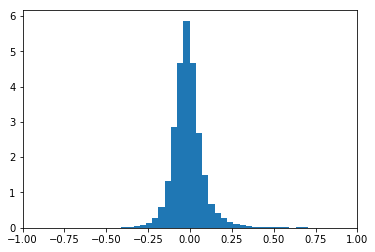

In [22]:
y_predict = model.predict(X_realTT_norm)
error_percent = (y_predict.reshape(-1) - y_realTT.reshape(-1))/y_realTT.reshape(-1)
errpd = plt.hist(error_percent,2000,normed=True)
plt.xlim([-1, 1])

In [ ]:
pickle.dump( errpd, open( "errpd"+str(fsize)+".pickle", "wb" ) )

In [ ]:
errpd_5 = pickle.load( open( "errpd"+str(5)+".pickle", "rb" ) )
errpd_9 = pickle.load( open( "errpd"+str(9)+".pickle", "rb" ) )

In [ ]:
model1_5 = np.loadtxt('pdf_errVdrift5X5X5')
model2_5 = np.loadtxt('pdf_errKbbMod5X5X5')
model1_9 = np.loadtxt('pdf_errVdrift9X9X9')
model2_9 = np.loadtxt('pdf_errKbbMod9X9X9')

In [ ]:
plt.plot(errpd_5[1][1:]+(errpd_5[1][1]-errpd_5[1][0])/2,errpd_5[0],'b')
plt.plot(model1_5[:,0], model1_5[:,1],'g')
plt.plot(model2_5[:,0], model2_5[:,1],'r')

plt.plot(errpd_9[1][1:]+(errpd_9[1][1]-errpd_9[1][0])/2,errpd_9[0],'--b')
plt.plot(model1_9[:,0], model1_9[:,1],'--g')
plt.plot(model2_9[:,0], model2_9[:,1],'--r')

plt.xlim([-1, 1])


In [ ]:
np.argsort(np.abs(np.sum(model.layers[0].get_weights()[0],axis=1)))

In [ ]:
np.sort(np.abs(np.sum(model.layers[0].get_weights()[0],axis=1)))

In [ ]:
mean, cov = [0, 2], [(1, .5), (.5, 1)]
x, y = np.random.multivariate_normal(mean, cov, size=50).T
ax = sns.kdeplot(x)

In [ ]:
sns.kdeplot(error_percent)

In [ ]:
ah[0].shape

In [ ]:
plt.scatter(ah[1],ah[0])

In [ ]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

# this create the kernel, given an array it will estimate the probability over that values
kde = gaussian_kde( error_percent )
# these are the values over wich your kernel will be evaluated
dist_space = linspace( min(error_percent), max(error_percent), 100 )
# plot the results
plt.plot( dist_space, kde(dist_space) )
plt.xlim([-1,1])

In [ ]:
#Us_2 = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in Us])

In [ ]:
#Us[-1]

In [ ]:
#Us_2[-1]